In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Owner\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [25]:
df = pd.read_csv('all_en_lyrics_processed_new.csv')
print(f"Data shape: {df.shape}")
print(f"Rows with missing sentiment_score: {df['sentiment_score'].isnull().sum()}")

df_clean = df.dropna(subset=['sentiment_score', 'clean_lyrics']).copy()
df_clean = df_clean[df_clean['clean_lyrics'].str.strip() != ''].copy()

# binary label needed for RoBERTa version, not Cardiff
df_clean['sentiment_binary'] = (df_clean['sentiment_score'] > 0).astype(int)

print(f"Sentiment distribution:\n{df_clean['sentiment_binary'].value_counts()}")

df = df_clean

Original dataset shape: (10872, 18)
Rows with missing sentiment_score: 62
Sentiment distribution:
sentiment_binary
0    9406
1    1404
Name: count, dtype: int64


In [5]:
tfidf = TfidfVectorizer(
    max_features=5000, 
    min_df=2,         
    max_df=0.8,        
    stop_words='english',
    ngram_range=(1, 2) 
)

X_tfidf = tfidf.fit_transform(df['clean_lyrics'].fillna(''))
feature_names = tfidf.get_feature_names_out()

print(f"TF-IDF matrix shape: {X_tfidf.shape}")

Creating TF-IDF features...
TF-IDF matrix shape: (10810, 5000)


In [6]:
y = df['sentiment_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    C=1.0, 
    class_weight='balanced' 
)

lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]

Training set shape: (8648, 5000)
Test set shape: (2162, 5000)
Training logistic regression model...


In [7]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {roc_auc:.3f}")

cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      1881
           1       0.55      0.82      0.66       281

    accuracy                           0.89      2162
   macro avg       0.76      0.86      0.79      2162
weighted avg       0.92      0.89      0.90      2162


Confusion Matrix:
[[1689  192]
 [  50  231]]

ROC AUC Score: 0.928
Cross-validation accuracy: 0.886 (+/- 0.020)


In [8]:
# Feature Importance Analysis
feature_coefficients = lr_model.coef_[0]

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': feature_coefficients,
    'abs_coefficient': np.abs(feature_coefficients)
}).sort_values('abs_coefficient', ascending=False)

print("Top 15 POSTIVE features:")
top_positive = feature_importance_df.nlargest(15, 'coefficient')
for idx, row in top_positive.iterrows():
    print(f"{row['feature']:20s} Coef:{row['coefficient']:8.4f}")

print("\nTop 15 NEGATIVE features:")
top_negative = feature_importance_df.nsmallest(15, 'coefficient')
for idx, row in top_negative.iterrows():
    print(f"{row['feature']:20s} Coef:{row['coefficient']:8.4f}")

print("\nTop 20 most important features (by absolute coefficient):")
top_important = feature_importance_df.head(20)
for idx, row in top_important.iterrows():
    print(f"{row['feature']:20s} Coef:{row['abs_coefficient']:8.4f}")

Top 15 POSTIVE features:
love                 Coef:  5.8922
beautiful            Coef:  5.0976
happy                Coef:  4.6945
good                 Coef:  4.4025
best                 Coef:  3.6122
day                  Coef:  3.0222
wonderful            Coef:  2.9568
fun                  Coef:  2.7382
congratulations      Coef:  2.7304
baby                 Coef:  2.6964
loving               Coef:  2.6441
better               Coef:  2.6319
life                 Coef:  2.6129
ll                   Coef:  2.5298
eternity             Coef:  2.4553

Top 15 NEGATIVE features:
don                  Coef: -3.2111
left                 Coef: -3.1555
fuck                 Coef: -3.0053
shit                 Coef: -2.9088
said                 Coef: -2.7112
ain                  Coef: -2.6868
saw                  Coef: -2.5717
blood                Coef: -2.5392
fight                Coef: -2.4164
dead                 Coef: -2.3963
broken               Coef: -2.3852
ah                   Coef: -2.3348
tel

In [9]:
# Ablation Analysis
feature_groups = {
    'unigrams': [f for f in feature_names if ' ' not in f],
    'bigrams': [f for f in feature_names if ' ' in f],
    'positive_words': ['love', 'happy', 'good', 'great', 'beautiful', 'wonderful'],
    'negative_words': ['hate', 'sad', 'bad', 'terrible', 'awful', 'horrible']
}

filtered_groups = {}
for group_name, words in feature_groups.items():
    if group_name in ['unigrams', 'bigrams']:
        filtered_groups[group_name] = words
    else:
        filtered_groups[group_name] = [w for w in words if w in feature_names]

ablation_results = []

baseline_score = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='accuracy').mean()
ablation_results.append({
    'removed_features': 'none (baseline)',
    'num_features_removed': 0,
    'remaining_features': X_train.shape[1],
    'cv_accuracy': baseline_score
})

print(f"Baseline accuracy (all features): {baseline_score:.4f}")

for group_name, group_features in filtered_groups.items():
    if len(group_features) == 0:
        continue

    if group_name in ['unigrams', 'bigrams']:
        feature_indices_to_remove = [i for i, f in enumerate(feature_names) if f in group_features]
    else:
        feature_indices_to_remove = [i for i, f in enumerate(feature_names) if f in group_features]
    
    if len(feature_indices_to_remove) == 0:
        continue

    feature_mask = np.ones(X_train.shape[1], dtype=bool)
    feature_mask[feature_indices_to_remove] = False

    X_train_ablated = X_train[:, feature_mask]
    
    lr_ablated = LogisticRegression(
        random_state=42, max_iter=1000, C=1.0, class_weight='balanced'
    )
    
    ablated_score = cross_val_score(lr_ablated, X_train_ablated, y_train, cv=5, scoring='accuracy').mean()
    
    ablation_results.append({
        'removed_features': group_name,
        'num_features_removed': len(feature_indices_to_remove),
        'remaining_features': X_train.shape[1] - len(feature_indices_to_remove),
        'cv_accuracy': ablated_score,
        'accuracy_drop': baseline_score - ablated_score
    })
    
    print(f"Without {group_name:15s}: {ablated_score:.4f} (drop: {baseline_score - ablated_score:+.4f})")

ablation_df = pd.DataFrame(ablation_results)
print("\nAblation Analysis Summary:")
print(ablation_df.to_string(index=False))

Baseline accuracy (all features): 0.8863
Without unigrams       : 0.8191 (drop: +0.0672)
Without bigrams        : 0.8720 (drop: +0.0143)
Without positive_words : 0.8738 (drop: +0.0125)
Without negative_words : 0.8863 (drop: +0.0000)

Ablation Analysis Summary:
removed_features  num_features_removed  remaining_features  cv_accuracy  accuracy_drop
 none (baseline)                     0                5000     0.886333            NaN
        unigrams                  3140                1860     0.819149   6.718421e-02
         bigrams                  1860                3140     0.871994   1.433907e-02
  positive_words                     6                4994     0.873844   1.248876e-02
  negative_words                     4                4996     0.886333   1.337269e-07


In [10]:
# Top features by frequency
feature_frequencies = np.array(X_tfidf.sum(axis=0)).flatten()
freq_df = pd.DataFrame({
    'feature': feature_names,
    'frequency': feature_frequencies,
    'coefficient': feature_coefficients
}).sort_values('frequency', ascending=False)

print("Top 15 most frequent features:")
for idx, row in freq_df.head(15).iterrows():
    print(f"{row['feature']:10s}  Freq: {row['frequency']:8.2f} | Coef: {row['coefficient']:8.4f}")

Top 15 most frequent features:
don         Freq:   331.51 | Coef:  -3.2111
love        Freq:   313.21 | Coef:   5.8922
know        Freq:   301.22 | Coef:  -1.3320
like        Freq:   301.04 | Coef:  -0.2950
oh          Freq:   288.93 | Coef:   0.8839
ll          Freq:   272.03 | Coef:   2.5298
just        Freq:   270.18 | Coef:  -1.5395
yeah        Freq:   244.48 | Coef:  -0.2488
got         Freq:   226.75 | Coef:  -1.1123
time        Freq:   211.62 | Coef:   0.2737
ve          Freq:   209.94 | Coef:  -0.7241
let         Freq:   197.86 | Coef:   0.6736
come        Freq:   171.81 | Coef:   0.5656
want        Freq:   168.19 | Coef:   0.0040
baby        Freq:   164.76 | Coef:   2.6964


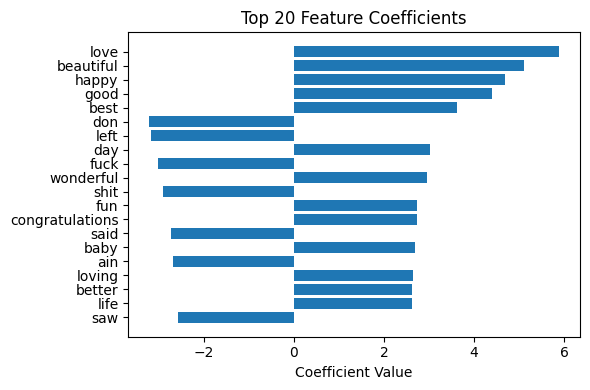

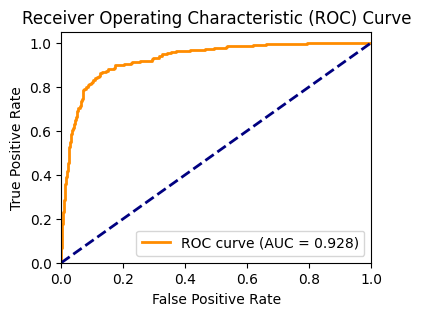

In [11]:
# Plot feature importance
plt.figure(figsize=(6, 4))
top_features = feature_importance_df.head(20)
plt.barh(range(len(top_features)), top_features['coefficient'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 20 Feature Coefficients')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('Top_20_feature_coefs_processed_new.png')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('ROC_curve_processed_new.png')
plt.show()

In [12]:
print(f"Total number of features: {X_tfidf.shape[1]}")
print(f"Most important positive feature: {feature_importance_df.iloc[0]['feature']}")
print(f"Most important negative feature: {feature_importance_df.iloc[-1]['feature']}")

Total number of features: 5000
Most important positive feature: love
Most important negative feature: age love
